# Introduction

*In this challenge you will be asked to build a deep learning solution capable of segmenting turtles on synthetic images. You will be provided with the data, which you can use to train your models; your best model will be used on a test image and you will be asked to implement some geometric algorithms based on the predictions of your model.*

***Training data***

The training data will consist of 30 256x256 images of the same synthetic turtle pasted on background images artificially generated by BigGAN (https://arxiv.org/abs/1809.11096).

Feel free to increase the dataset size as needed and make any relevant changes to the dataset creation.

Each image will come with the ground truth per-pixel segmentation mask which you can leverage for your training setup. We strongly recommend that you treat the provided task as semantic segmentation with 2 classes -- foreground (turtle) and background (everything else).

You are also allowed to use external data sources and pre-trained weights, but please provide justification if you choose to do so.


***Test data***

There will only be a single test image without the provided GT.

The test image differs from the training data and it is up to you to decide how to approach these differences. Notably, the test image is of resolution 512x512 and your predicted mask must be of the same resolution.


***Tasks***

1. Your main task is to build a deep learning model capable of accurately segmenting the turtle in the test image.
2. Based on the segmentation mask predicted by your model, you will need to implement an algorithm that finds a **convex hull** (not concave), i.e. a polygon enclosing all the foreground (i.e. turtle) pixels.
3. Implement an algorithm that calculates the area of the polygon from the result of task 2.

*** Do not use model abstraction libraries such as TIMM, Transformers, or the models from TorchVision to create your segmentation model. You should use the PyTorch API to create a torch.nn.Module subclass defining your model.***

***Rules***

* Please use PyTorch to train your model in task 1.
* Feel free to use all the imported Python libraries
* For tasks 2 and 3 ***you are not allowed*** to use third-party functions that readily solve those tasks, e.g. you are not allowed to use various `cv2` and `scikit-image` operators. We expect the algorithms to be based on points and geometry rather than full-image operations.
* You may modify any provided code, please provide explanation for any significant changes.


***Submission***

* ***You must send us only a single link to the Colab notebook with your solution and nothing else!*** We must be able to reproduce your results by running the notebook in the browser as is. Be careful not to use too much RAM (12G) or GPU (15G) so it does not crash. If you require additional files, use `gdown` to download them into the session storage (see Task 1 for details).
* Include your comments and explanations on the decisions that you made to approach the problem;
* Make sure to include the estimate of approximately how much time it took you to get to the final solution.

***Grading Criteria***

* Output must be correct for all 3 tasks
* Should run in reasonable time without significant inefficiencies. Ideally < 10 minutes, training can take a little longer if needed.
* Code should be clean and readable

***Colab setup***

* To use GPU, go to `Runtime -> Change Runtime Type -> GPU`

**Solution**

The solution here use the data augmentation and unet model for the segementation task. The entire notebook takes the around 10 to 15 mins to run when ran on the A100 gpu provided by the google colab. Furthermore, 200 images are used for the training of the model.

In [ ]:
# comment the following line if you are working outside of a notebook environment
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

In [ ]:
# Used to download any files you need for your solution from Google Drive
import gdown
gdown.download("https://drive.google.com/uc?id=1ymKI8M73kBIck2b7S7QG02aiP4yXLaML", "turtle.png", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ymKI8M73kBIck2b7S7QG02aiP4yXLaML
To: /content/turtle.png
100%|██████████| 692k/692k [00:00<00:00, 135MB/s]


'turtle.png'

In [ ]:
# read and visualise the turtle image
turtle_image = Image.open('./turtle.png')
# it is a 4-channel RGB+Alpha image of size 2394x1800
print(turtle_image.mode, turtle_image.size)

RGBA (2394, 1800)


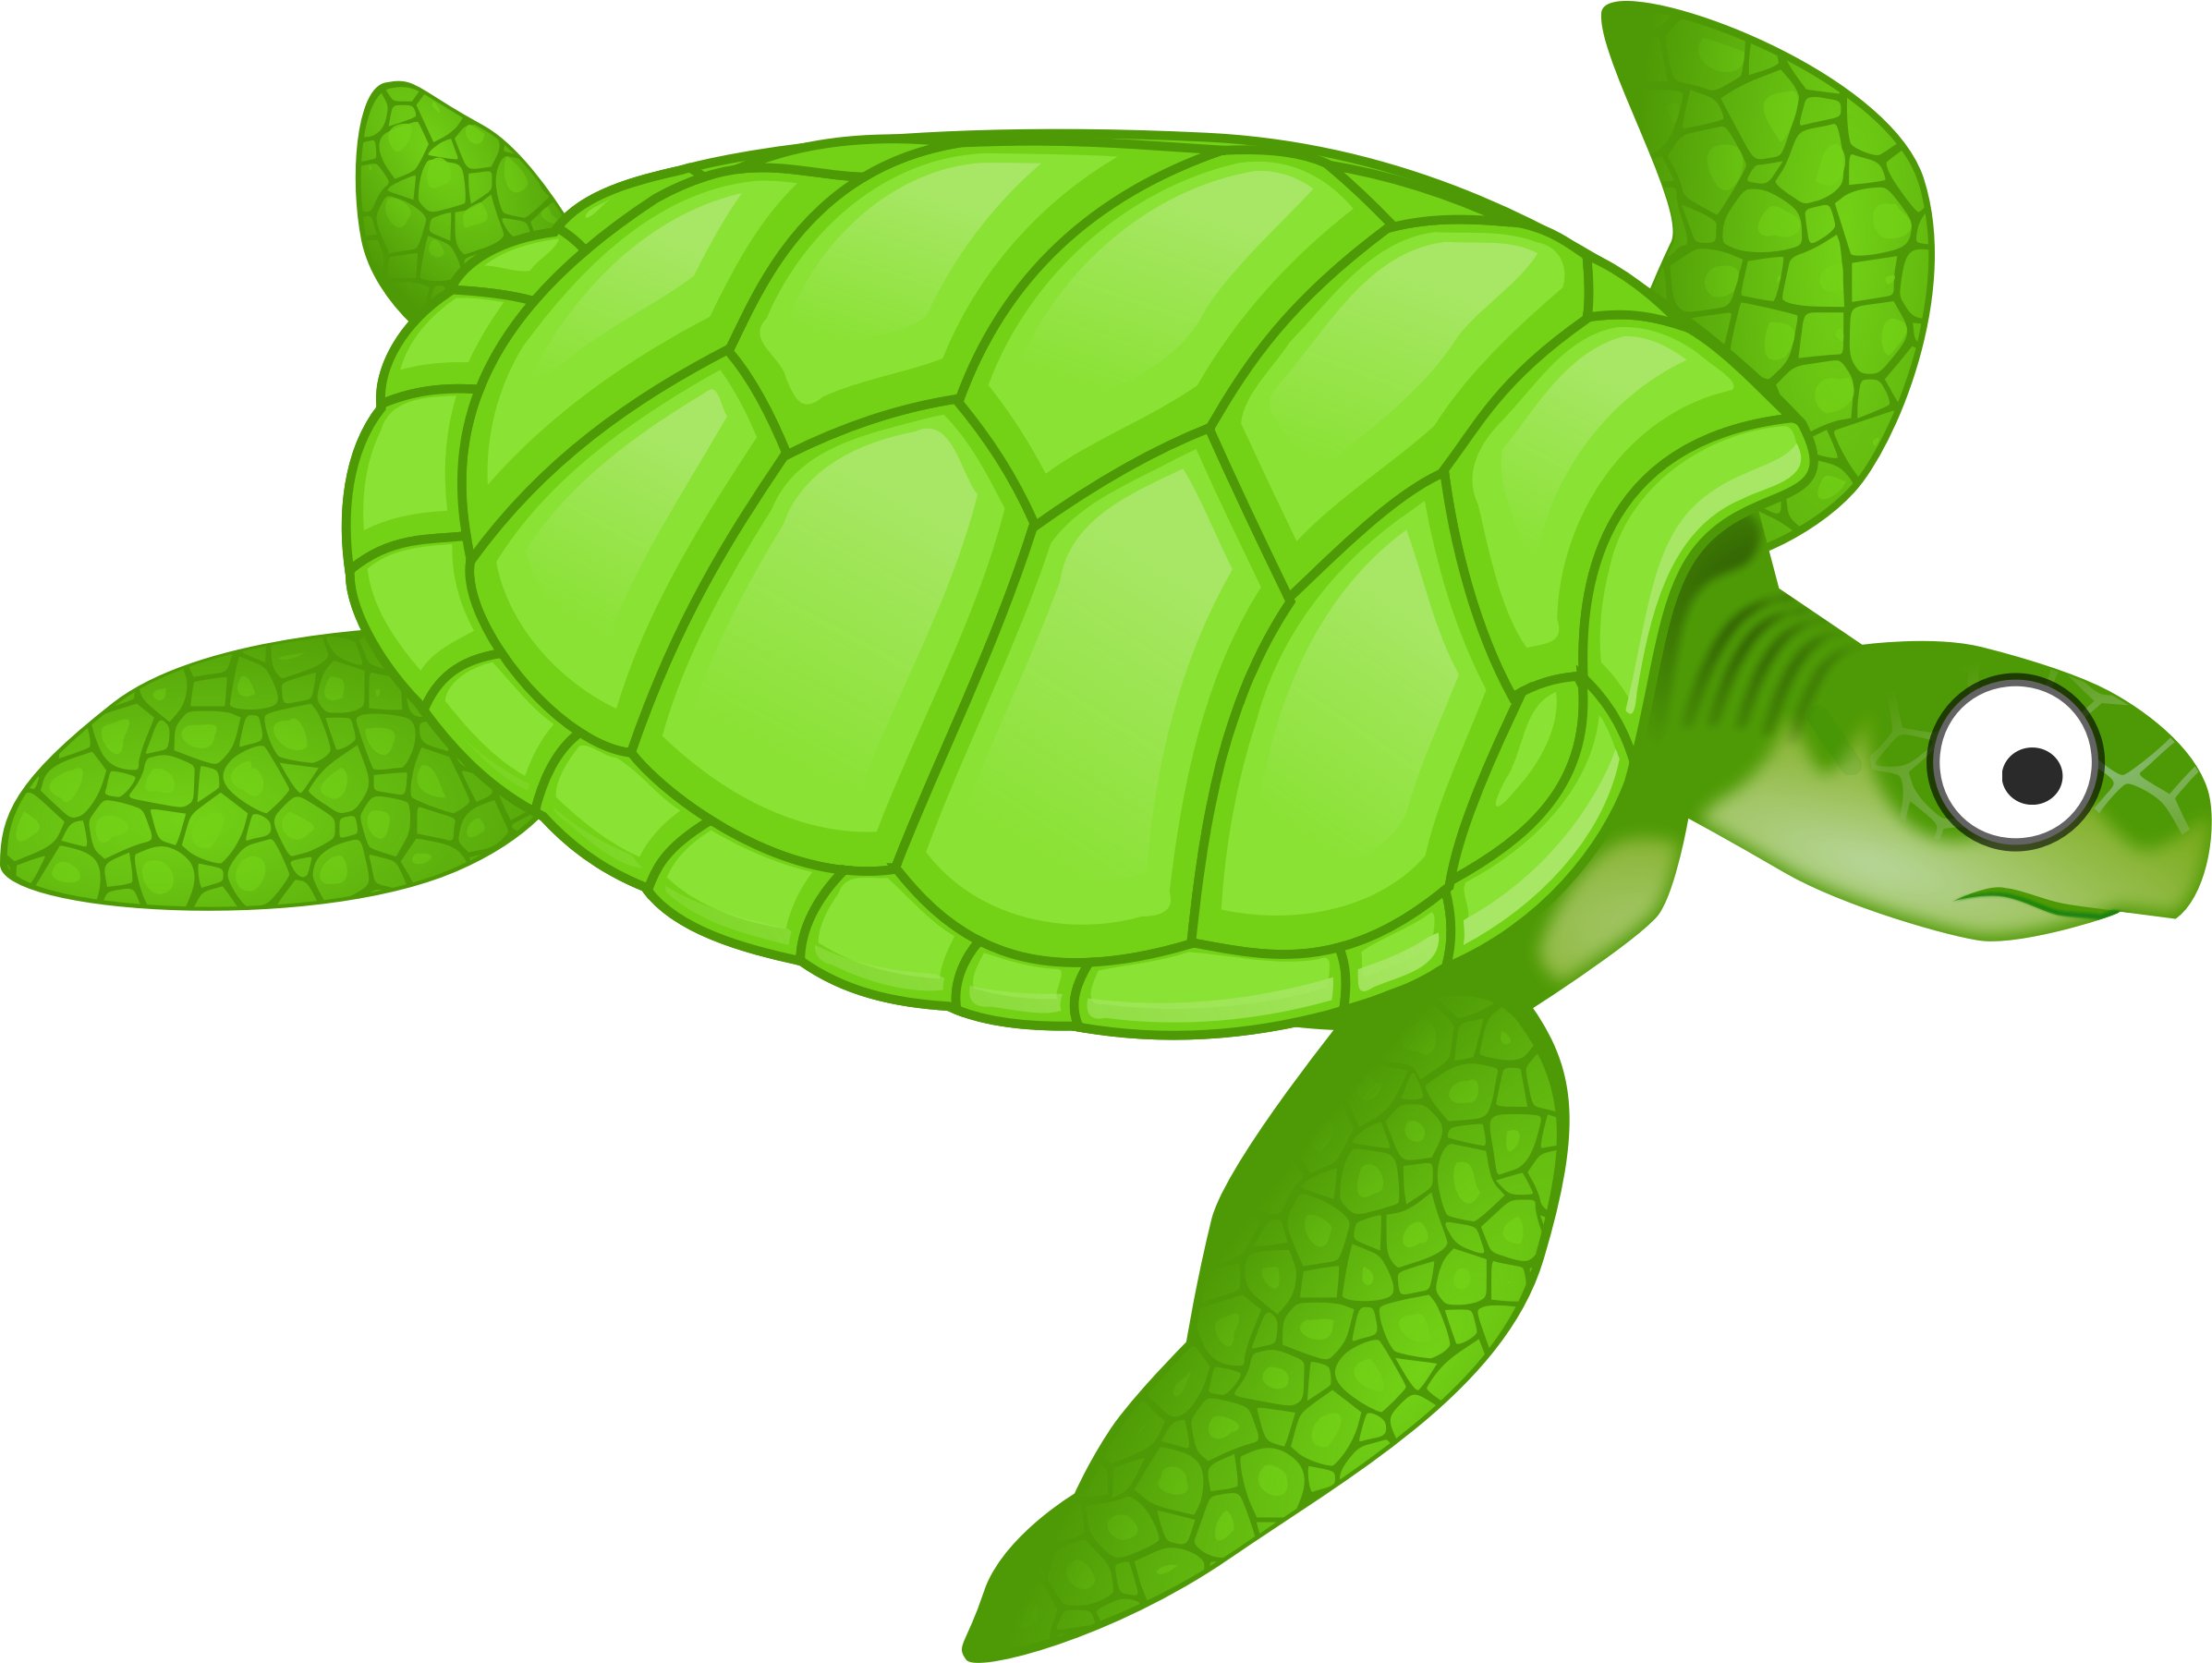

In [ ]:
turtle_image

In [ ]:
# to create the training set, we will resize the turtle image to 256x256
turtle_image_256x256 = turtle_image.resize((256, 256))

# Background Images

As written above, we will use a generative adversarial network called "BigGAN" pre-trained on ImageNet to create a set of background images

In [ ]:
# first, we need to install the python package called `pytorch_pretrained_biggan` (https://github.com/huggingface/pytorch-pretrained-BigGAN)
# if in the notebook environment, please uncomment the following line to install this package
!pip install pytorch_pretrained_biggan
# there might be some errors related to pip's dependency resolver which you can safely ignore

In [ ]:
import torch
from pytorch_pretrained_biggan import (
    BigGAN,
    truncated_noise_sample,
    convert_to_images,
    one_hot_from_int,
)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# boilerplate pytorch code enforcing reproducibility
torch.manual_seed(42)
if device.type == "cuda":
    torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)

BigGAN is a memory-intensive network.

To save time and memory, we will only generate 30 different background images.
Feel free to change this setup as needed.

In [ ]:
# load the 256x256 model
model = BigGAN.from_pretrained('biggan-deep-256').to(device).eval()

# every time we will run with batch size of 3 in order to not run out of memory
num_passes = 20
batch_size = 10

# default noise value from the provided repository
truncation = 0.4

background_images = []

for _ in range(num_passes):
    # BigGAN uses imagenet and hence each time we will choose one of 1000 categories
    class_vector = torch.from_numpy(
        one_hot_from_int(np.random.randint(0, 1000, size=batch_size), batch_size=batch_size)
    ).to(device)
    noise_vector = torch.from_numpy(
        truncated_noise_sample(truncation=truncation, batch_size=batch_size)
    ).to(device)

    # Generate the images and convert them to PIL image
    with torch.no_grad():
        output = model(noise_vector, class_vector, truncation).cpu()
        background_images.extend(convert_to_images(output))

# We won't need the GAN model anymore,
# so we can safely delete it and free up some memory
del model
torch.cuda.empty_cache()

/usr/local/lib/python3.11/dist-packages/pytorch_pretrained_biggan/model.py:279: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(resolved_model_file, ma

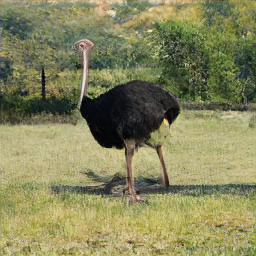

In [ ]:
# Let's see how one of the images look like
random.choice(background_images)

# Training Set
Given 30 background images and the turtle image, we will paste the turtle onto the background images.

In [ ]:
import torchvision
import torchvision.transforms as transforms

In [ ]:
tensor_transform = transforms.ToTensor()

def random_paste(background_image, turtle_image, min_scale=0.25, max_scale=0.65):
    """Randomly scales and pastes the turtle image onto the background image"""

    w, h = turtle_image.size
    # first, we will randomly downscale the turtle image
    new_w = int(random.uniform(min_scale, max_scale) * w)
    new_h = int(random.uniform(min_scale, max_scale) * h)
    resized_turtle_image = turtle_image.resize((new_w, new_h))

    # second, will randomly choose the locations where to paste the new image
    start_w = random.randint(0, w - new_w)
    start_h = random.randint(0, h - new_h)

    # third, will create the blank canvas of the same size as the original image
    canvas_image = Image.new('RGBA', (w, h))

    # and paste the resized turtle onto it, preserving the mask
    canvas_image.paste(resized_turtle_image, (start_w, start_h), resized_turtle_image)

    # Turtle image is of mode RGBA, while background image is of mode RGB;
    # `.paste` requires both of them to be of the same type.
    background_image = background_image.copy().convert('RGBA')
    # finally, will paste the resized turtle onto the background image
    background_image.paste(resized_turtle_image, (start_w, start_h), resized_turtle_image)
    return background_image, canvas_image

In [ ]:
training_set = []  # image, segmentation mask

for background_image in background_images:
  # paste the turtle onto background image
  aug_image, aug_mask = random_paste(background_image.copy(), turtle_image_256x256.copy())
  # convert PIL images to pytorch tensors
  training_pair = [
      tensor_transform(aug_image)[:3],  # keep the rgb only
      # For the mask, we only need the last (4th) channel,
      # and we will encode the mask as boolean
      tensor_transform(aug_mask)[-1:] > 0,
  ]
  training_set.append(training_pair)

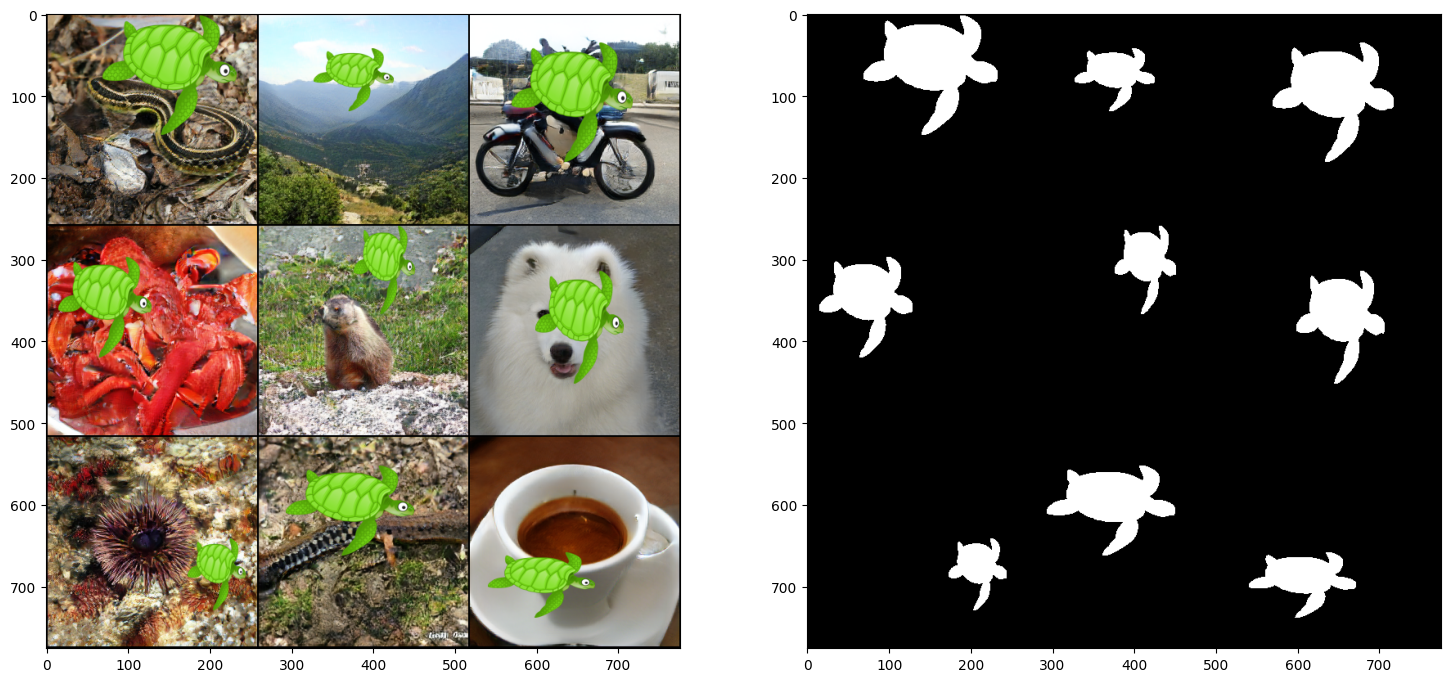

In [ ]:
# Let's visualise some subset of the training set
sample_indices = np.random.choice(len(training_set), size=9, replace=False)
sample_images = []
sample_masks = []
for i in sample_indices:
    image, mask = training_set[i]
    sample_images.append(image)
    sample_masks.append(mask)

plt.figure(figsize=(18, 18))
plt.subplot(121)
plt.imshow(torchvision.utils.make_grid(sample_images, nrow=3).permute(1, 2, 0).cpu().numpy())
plt.subplot(122)
plt.imshow(torchvision.utils.make_grid(sample_masks, nrow=3).permute(1, 2, 0).float().cpu().numpy())

# Test Image
Now, let's load the test image. As mentioned above, it is of a slightly higher 512x512 resolution.

Downloading...
From: https://drive.google.com/uc?id=1_55KX8AK8pZ936Zv27t8Q-ZY8BJjuBqa
To: /content/test.png
100%|██████████| 413k/413k [00:00<00:00, 87.1MB/s]

RGB (512, 512)


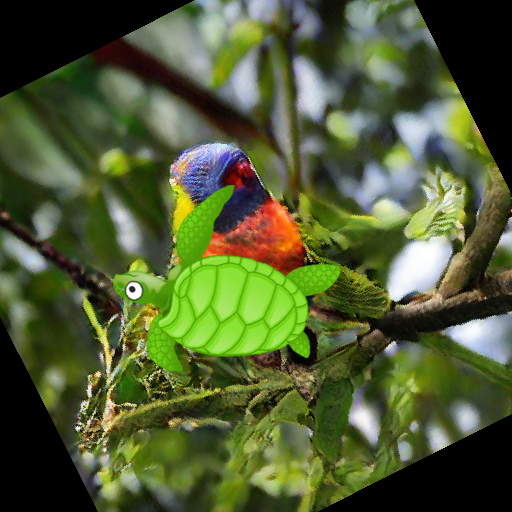

In [ ]:
gdown.download("https://drive.google.com/uc?id=1_55KX8AK8pZ936Zv27t8Q-ZY8BJjuBqa", "test.png", quiet=False)
test_image = Image.open('./test.png')
# it is a 3-channel RGB image of size 512x512
print(test_image.mode, test_image.size)
test_image

# Task 1: Predicting segmentation mask

*This is where you need to implement your deep learning solution. Your approach must output a result at the native 512x512 resolution of the test image.*

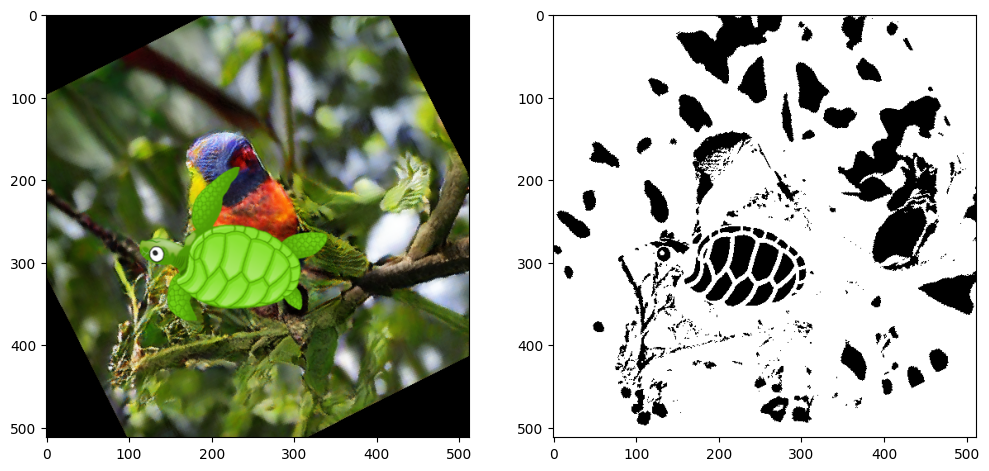

In [ ]:
# TODO: Implement and train the deep model

# TODO: Save the model weights and upload them to Google Drive

load_model_weights = False
if load_model_weights:
    # After uploading your saved model weights to Google Drive, share to
    # "Anyone with the link" and extract FILE_ID from the share link
    # See https://support.google.com/drive/answer/2494822?hl=en&co=GENIE.Platform%3DDesktop
    # for more information
    # Now the weights can be downloaded and used via gdown:
    saved_model_url = "https://drive.google.com/uc?id=FILE_ID"
    gdown.download(saved_model_url, "saved_model.pth", quiet=True)

    # TODO: Load your saved model weights e.g. torch.load("saved_model.pth")

test_image_tensor = tensor_transform(test_image)

def get_mask_from_image(test_image):
  # TODO: Use the deep model that predicts the segmentation mask on the test image
  # The model with the saved weights should be used, if load_model_weights is True
  test_mask = test_image.mean(0) < 0.5
  return test_mask.byte()

test_mask_tensor = get_mask_from_image(test_image_tensor)

plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(test_image_tensor.numpy().transpose(1, 2, 0))
plt.subplot(122)
plt.imshow(test_mask_tensor.numpy(), cmap="gray", vmin=0, vmax=1)

Training loop

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import random
from PIL import Image

In [ ]:
"""Here I have done data augmentation to have better result for different images size and rotation"""
class Dataturtle(Dataset):
    def __init__(self, data, transform=True):
        self.data = data
        self.transform = transform
        self.augment = transforms.Compose([
            transforms.RandomRotation(30),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
            transforms.RandomResizedCrop((256, 256), scale=(0.5, 1.5)),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225]),
        ])
    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
        img, mask = self.data[idx]

        if self.transform:
            if mask.dtype == torch.bool:
                mask = mask.float()

            img_mask = torch.cat([img, mask])

            if random.random() > 0.5:
                img_mask = TF.rotate(img_mask, random.uniform(-30, 30))
            if random.random() > 0.5:
                img_mask = TF.hflip(img_mask)
            if random.random() > 0.5:
                img_mask = TF.vflip(img_mask)


            img = img_mask[:3]
            mask = img_mask[3:]

        return img, mask.bool()

train_loader = Dataturtle(training_set, transform=True)
train_set=DataLoader(train_loader, batch_size=10, shuffle=True)

In [ ]:
"""The loss function is the combination of the Dice loss and the bce loss for the better task of segmentation"""
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        intersection = (probs * targets).sum(dim=(2,3))
        denom = probs.sum(dim=(2,3)) + targets.sum(dim=(2,3))
        dice = (2. * intersection + self.smooth) / (denom + self.smooth)
        return 1 - dice.mean()

bce = nn.BCEWithLogitsLoss()
dice_loss_fn = DiceLoss()

def loss_fn(logits, targets):
    return 0.5 * bce(logits, targets) + 0.5 * dice_loss_fn(logits, targets)



In [ ]:
"""Here I have used the UNET model as its one of the best model for the segemntation task. There are encoder and decoder used here as well the bottleneck """
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.encoder2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.encoder3 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        # Decoder
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)

        # Bottleneck
        bottleneck = self.bottleneck(enc3)

        # Decoder
        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.decoder1(dec1)

        out = self.final(dec1)
        return out


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model= UNet(in_channels=3,out_channels=1).to(device)
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-3, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True,min_lr=1e-6)
# criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Train U-Net
num_epoch=100
for epochs in range(num_epoch):
  model.train()
  running_loss=0.0
  for batch , (image,mask) in enumerate(train_set):
    image=image.to(device)
    mask=mask.to(device).float()
    pred=model(image)
    loss=loss_fn(pred,mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * image.size(0)
  scheduler.step(running_loss)
  running_loss /= len(train_set.dataset)
  print(f"Epoch [{epochs+1}/{num_epoch}] Loss: {running_loss:.4f}")


torch.save(model.state_dict(), "unet.pth")

Epoch [1/100] Loss: 0.5452
Epoch [2/100] Loss: 0.4417
Epoch [3/100] Loss: 0.3490
Epoch [4/100] Loss: 0.3034
Epoch [5/100] Loss: 0.2260
Epoch [6/100] Loss: 0.1711
Epoch [7/100] Loss: 0.1423
Epoch [8/100] Loss: 0.1138
Epoch [9/100] Loss: 0.0848
Epoch [10/100] Loss: 0.0701
Epoch [11/100] Loss: 0.0592
Epoch [12/100] Loss: 0.0563
Epoch [13/100] Loss: 0.0443
Epoch [14/100] Loss: 0.0424
Epoch [15/100] Loss: 0.0352
Epoch [16/100] Loss: 0.0324
Epoch [17/100] Loss: 0.0347
Epoch [18/100] Loss: 0.0288
Epoch [19/100] Loss: 0.0313
Epoch [20/100] Loss: 0.0249
Epoch [21/100] Loss: 0.0243
Epoch [22/100] Loss: 0.0213
Epoch [23/100] Loss: 0.0228
Epoch [24/100] Loss: 0.0537
Epoch [25/100] Loss: 0.0392
Epoch [26/100] Loss: 0.0333
Epoch [27/100] Loss: 0.0319
Epoch [28/100] Loss: 0.0308
Epoch [29/100] Loss: 0.0235
Epoch [30/100] Loss: 0.0206
Epoch [31/100] Loss: 0.0318
Epoch [32/100] Loss: 0.0260
Epoch [33/100] Loss: 0.0205
Epoch [34/100] Loss: 0.0190
Epoch [35/100] Loss: 0.0171
Epoch [36/100] Loss: 0.0171
E

In [ ]:
def get_mask_from_image(test_image):
    """Predict segmentation mask using the trained model."""
    model.eval()
    with torch.no_grad():
        test_image = test_image.unsqueeze(0).to(device)  # Add batch dimension
        pred_mask = model(test_image)
    return (pred_mask.squeeze(0) > 0.5).byte()  # Threshold mask
test_mask_tensor = get_mask_from_image(test_image_tensor)
print(test_mask_tensor.shape)

torch.Size([1, 512, 512])


Unique Values in Mask: tensor([0, 1], device='cuda:0', dtype=torch.uint8)
torch.Size([1, 512, 512])


<ipython-input-54-e84268516832>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet.pth"))


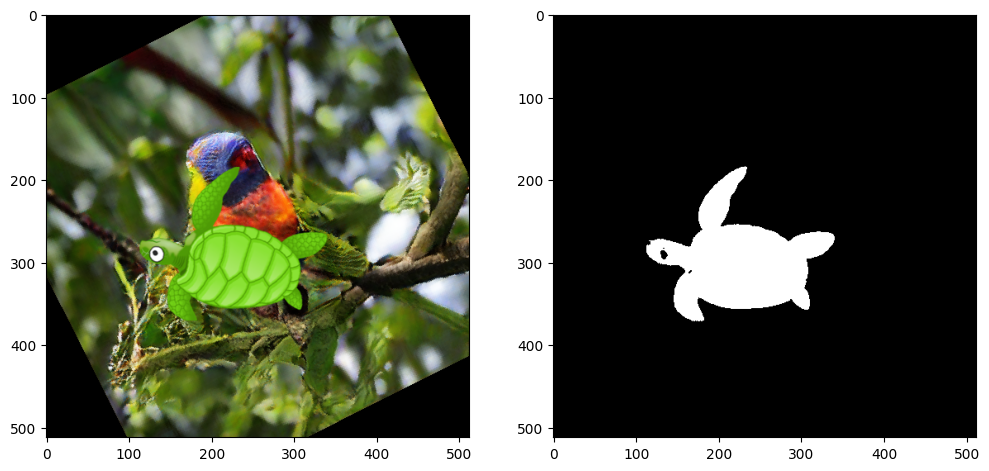

In [ ]:
# Load saved weights with `weights_only=True`
model.load_state_dict(torch.load("unet.pth"))

# Test the model
test_image_tensor = tensor_transform(test_image).to(device)
test_mask_tensor = get_mask_from_image(test_image_tensor)
print("Unique Values in Mask:", torch.unique(test_mask_tensor))
print(test_mask_tensor.shape)

# Visualize the results
plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(test_image_tensor.cpu().numpy().transpose(1, 2, 0))  # Ensure conversion to CPU for visualization

plt.subplot(122)
plt.imshow(test_mask_tensor.squeeze(0).cpu().numpy(), cmap="gray", vmin=0, vmax=1)  # Squeeze to remove extra channel
plt.show()

# Task 2: Calculating tight enclosing polygon from segmentation mask

*This is where you need to implement your algorithm that predicts a **convex hull** (not concave), an enclosing polygon of foreground pixels. You are not allowed to use cv2, scikit-image or other libraries' functionality that readily solve this task. Treat this problem as point-based (using pixel coordinates) rather than image-based.*

*You don't have to use PyTorch for this part. Your approach must output a result at the native 512x512 resolution of the test image.*

*For the purposes of this assignment, O(n^2) is considered a good time complexity*

In [ ]:
# def get_tight_polygon_from_mask(test_mask):
#   # TODO: Implement an algorithm that computes the enclosing polygon from the segmentation mask.
#   mask_points_n2 = torch.stack(torch.where(test_mask_tensor == 1), 1)
#   dummy_polygon_points_n2 = mask_points_n2[torch.randperm(mask_points_n2.size(0))[:3], :]
#   return dummy_polygon_points_n2

# def visualize_polygon_on_image(test_image, polygon_points_n2):
#   # append first point to close the figure
#   polygon_points_n2 = torch.cat([polygon_points_n2, polygon_points_n2[:1]], 0)
#   ys, xs = torch.split(polygon_points_n2, 1, dim=-1)
#   plt.figure(figsize=(12, 12))
#   plt.imshow(test_image.numpy().transpose(1, 2, 0))
#   plt.plot(xs.numpy(), ys.numpy())


# polygon_points_n2_tensor = get_tight_polygon_from_mask(test_mask_tensor)
# visualize_polygon_on_image(test_image_tensor, polygon_points_n2_tensor)


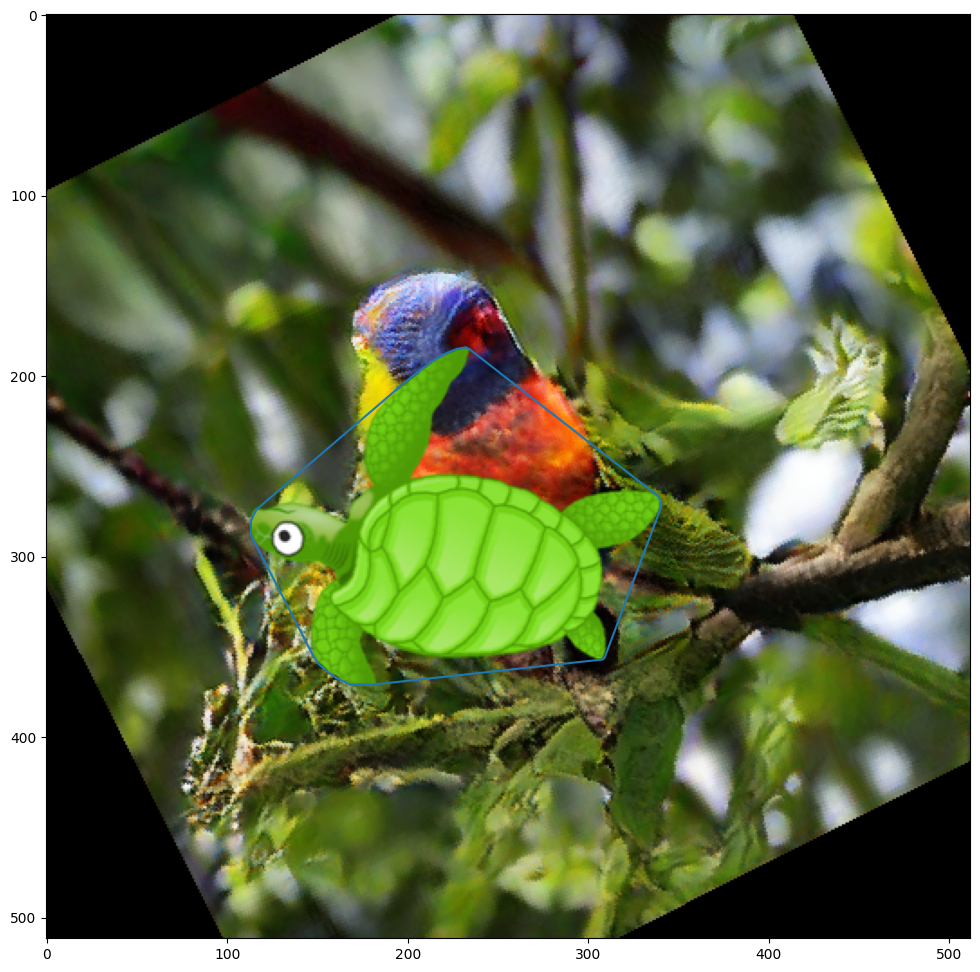

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
"""Here I have used the Jarvis’s March (Gift Wrapping) algorithm to find the convex hull of a set of points of the Images."""
def convex_hull_method(tensor_points):
    points = tensor_points.cpu().numpy()
    if len(points) < 3:
        return tensor_points

    convex_hull = []
    left_index = 0
    for i in range(1, len(points)):
        if (points[i, 1] < points[left_index, 1]) or ((points[i, 1] == points[left_index, 1]) and (points[i, 0] < points[left_index, 0])):
            left_index = i
    current_index = left_index

    while True:
        convex_hull.append(current_index)
        next_index = (current_index + 1) % len(points)

        for candidate_idx in range(len(points)):
            if candidate_idx == current_index:
                continue
            cp_value = cp_orientation(points[current_index], points[next_index], points[candidate_idx])
            if cp_value < 0:
                next_index = candidate_idx
            elif cp_value == 0:
                if distance(points[current_index], points[candidate_idx]) > distance(points[current_index], points[next_index]):
                    next_index = candidate_idx

        current_index = next_index
        if current_index == left_index:
            break

    convex_hull_points = points[convex_hull]
    convex_hull_tensor = torch.from_numpy(convex_hull_points).to(tensor_points.device)
    return convex_hull_tensor

def cp_orientation(x, y, z):
    return ( (y[1] - x[1])*(z[0] - x[0])
           - (y[0] - x[0])*(z[1] - x[1]) )

def distance(a, b):
    return (a[0] - b[0])**2 + (a[1] - b[1])**2

def get_tight_polygon_from_mask(test_mask_tensor):
    mask_points_n2 = torch.stack(torch.where(test_mask_tensor == 1), dim=1).float()
    polygon_points_n2 = convex_hull_method(mask_points_n2)

    return polygon_points_n2

def visualize_polygon_on_image(test_image, polygon_points_n2):
  # append first point to close the figure
  polygon_points_n2 = torch.cat([polygon_points_n2, polygon_points_n2[:1]], 0)
  ys, xs = torch.split(polygon_points_n2, 1, dim=-1)
  plt.figure(figsize=(12, 12))
  plt.imshow(test_image.cpu().numpy().transpose(1, 2, 0))
  plt.plot(xs.cpu().numpy(), ys.cpu().numpy())



test_mask_tensor = test_mask_tensor.squeeze(0)
polygon_points_n2_tensor = get_tight_polygon_from_mask(test_mask_tensor)
visualize_polygon_on_image(test_image_tensor, polygon_points_n2_tensor)



# Task 3: Calculating the area of the polygon

<!-- > Indented block -->


*This is where you need to implement your area calculation algorithm. You are not allowed to use cv2, scikit-image or other libraries' functionality that readily solve this task. Once again, treat this problem as a point-based rather than an image-based one.*

*You don't have to use PyTorch for this part. Your approach must output a result at the native 512x512 resolution of the test image.*

In [ ]:
# def calculate_polygon_area(polygon_points_n2):
#   # TODO: Implement the algorithm
#   area = 0.0
#   return area

# print("Area = {:.4f}".format(calculate_polygon_area(polygon_points_n2_tensor)))

In [ ]:
def calculate_polygon_area(points):
    if points.is_cuda:
        points = points.cpu()
    points_np = points.numpy()
    if not np.array_equal(points_np[0], points_np[-1]):
        points_np = np.vstack([points_np, points_np[0]])

    x = points_np[:, 0]
    y = points_np[:, 1]
    area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    return area
print("Area = {:.4f}".format(calculate_polygon_area(polygon_points_n2_tensor)))

Area = 28428.5000
